## Mount drive for Google CoLab

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Lets now import all the necessary modules....

In [1]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR


## Now let's setup device agnostic code.


In [2]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [3]:
class TorchVisionDataset(Dataset):
    def __init__(self,data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    
    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        #lazily open image
        image = Image.open(file_path)

        #convert to rgb
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label
        


In [21]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
# data_path = Path("/content/drive/MyDrive/ENSF645_FinalProject/") # directory for Colab
data_path = Path("Project_Dataset/") # directory for VSCode
image_path = data_path 

In [23]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [24]:
walk_through_dir(image_path)

There are 3 directories and 0 images in 'Project_Dataset'.
There are 3 directories and 0 images in 'Project_Dataset\test'.
There are 0 directories and 43 images in 'Project_Dataset\test\angular_leaf_spot'.
There are 0 directories and 43 images in 'Project_Dataset\test\bean_rust'.
There are 0 directories and 42 images in 'Project_Dataset\test\healthy'.
There are 3 directories and 0 images in 'Project_Dataset\train'.
There are 0 directories and 345 images in 'Project_Dataset\train\angular_leaf_spot'.
There are 0 directories and 348 images in 'Project_Dataset\train\bean_rust'.
There are 0 directories and 342 images in 'Project_Dataset\train\healthy'.
There are 3 directories and 0 images in 'Project_Dataset\validation'.
There are 0 directories and 44 images in 'Project_Dataset\validation\angular_leaf_spot'.
There are 0 directories and 45 images in 'Project_Dataset\validation\bean_rust'.
There are 0 directories and 44 images in 'Project_Dataset\validation\healthy'.


In [22]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "validation"

train_dir, test_dir, val_dir

(WindowsPath('Project_Dataset/train'),
 WindowsPath('Project_Dataset/test'),
 WindowsPath('Project_Dataset/validation'))

## Visualize an Image

A major process in any machine learning experiment is to "know the data".  We know that we have a variety of images in the dataset so lets have a look at one....

Random image path: Project_Dataset\train\angular_leaf_spot\angular_leaf_spot_train.189.jpg
Image class: angular_leaf_spot
Image height: 500
Image width: 500


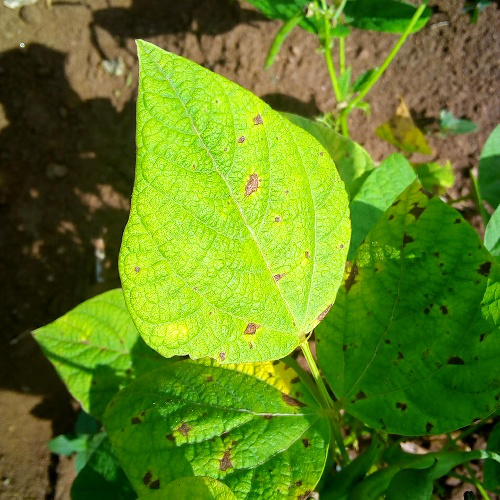

In [25]:
import random
from PIL import Image
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.*"))
image_path_list

#2. Get random image path
random_image_path = random.choice(image_path_list)

# # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# # 4. Open image
img = Image.open(random_image_path)

# # 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [26]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Writing the transforms for the data

In [29]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

## Visualizing some of the transformed images

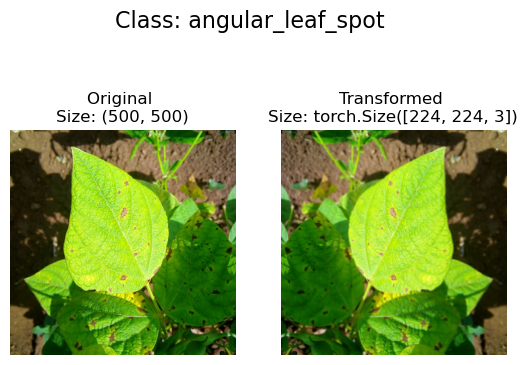

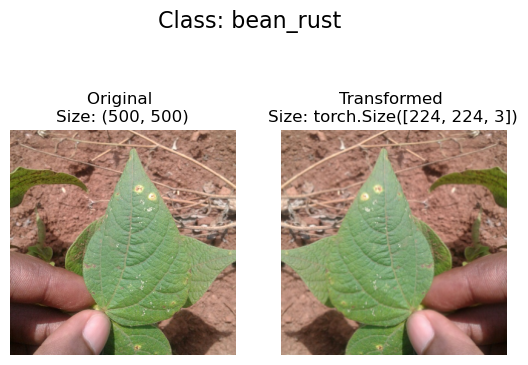

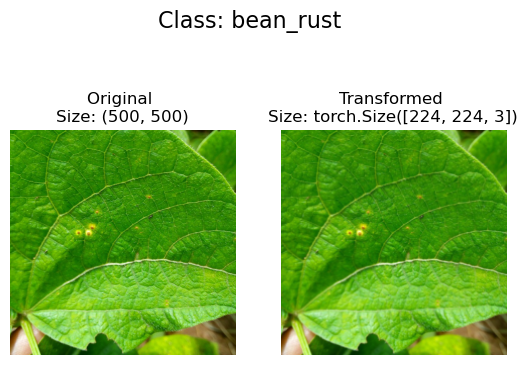

In [30]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

## Creating the datasets

In [31]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

val_data = datasets.ImageFolder(root=val_dir, 
                                 transform=data_transform)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nValidation data:\n{val_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1034
    Root location: Project_Dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Validation data:
Dataset ImageFolder
    Number of datapoints: 133
    Root location: Project_Dataset\validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 128
    Root location: Project_Dataset\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [32]:
# Get class names as a list
class_names = train_data.classes
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [33]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2}

In [34]:
# Check the lengths
len(train_data), len(test_data)

(1034, 128)

In [35]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.3725, 0.5961, 0.4863,  ..., 0.2196, 0.2157, 0.2157],
         [0.3647, 0.4902, 0.4824,  ..., 0.2078, 0.2000, 0.1961],
         [0.3843, 0.3176, 0.3804,  ..., 0.1922, 0.1843, 0.1843],
         ...,
         [0.4510, 0.4784, 0.4627,  ..., 0.2118, 0.2235, 0.2314],
         [0.5647, 0.5804, 0.6588,  ..., 0.2078, 0.2118, 0.2196],
         [0.6000, 0.5725, 0.6392,  ..., 0.1961, 0.2039, 0.2078]],

        [[0.2000, 0.4196, 0.3137,  ..., 0.1255, 0.1451, 0.1451],
         [0.2196, 0.3412, 0.3216,  ..., 0.1216, 0.1333, 0.1333],
         [0.2314, 0.1686, 0.2314,  ..., 0.1176, 0.1255, 0.1255],
         ...,
         [0.5412, 0.4824, 0.3843,  ..., 0.0902, 0.1059, 0.1137],
         [0.6863, 0.6588, 0.5922,  ..., 0.0941, 0.0941, 0.1020],
         [0.6980, 0.6431, 0.5373,  ..., 0.0863, 0.0902, 0.0902]],

        [[0.1333, 0.3176, 0.2275,  ..., 0.0000, 0.0039, 0.0039],
         [0.1412, 0.2275, 0.2157,  ..., 0.0000, 0.0039, 0.0039],
         [0.1843, 0.1255, 0.1725,  ..., 0.00

## Turn train and test Datasets into DataLoaders

In [36]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17f0c336c40>,
 <torch.utils.data.dataloader.DataLoader at 0x17f0c336f10>)

In [37]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


Selecting the pretrained model and weights

In [38]:
selected_model=resnet18
pretrained_weights=ResNet18_Weights.IMAGENET1K_V1

Using the same transforms as what was used for the model training.
For training, additional random horizontal and vertical flips are added.

Define training, validation and testings Datasets and Dataloaders

In [39]:
train_data

Dataset ImageFolder
    Number of datapoints: 1034
    Root location: Project_Dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Showing training data statistics and examples

In [40]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

print(get_dataset_stats(train_dataloader))

(tensor([0.4851, 0.5184, 0.3118]), tensor([0.1707, 0.1890, 0.1571]))


In [41]:
train_iterator = iter(train_dataloader)
train_batch = next(train_iterator)

In [42]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([1, 3, 224, 224])
torch.Size([1])


## Defining the Model

Defining model extension of nn.Module which will load the selected model's feature extractor and add a linear classifier layer on top.  
This class will load the selected model's pretrained weights if transfer is true. The model will also fix the feature extractor layer and not train the parameters if fixed_feature_extractor is true.

In [43]:
class Model(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False, fixed_feature_extractor=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # loading pretrained_weights if transfer is True
        self.feature_extractor =  selected_model(weights=(pretrained_weights if transfer else None))

        if fixed_feature_extractor:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x


Creating a model which will load the pretrained weights and fix the feature extractor parameters, only training the classifier.

In [44]:
net = Model(4, (3,224,224), transfer=True, fixed_feature_extractor=True)
net.to(device)

Model(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Defining the criterion, optimizer, and scheduler

In [45]:
# CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# selecting optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)

# exponential schedule will multiply the learning rate by gamma after each epoch
scheduler = ExponentialLR(optimizer, gamma=0.9)

Training

In [46]:
nepochs = 10
PATH = 'EV_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / (i+1):.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i+1):.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 0.991, val loss: 0.751
Saving model
2,  train loss: 0.712, val loss: 0.785
3,  train loss: 0.581, val loss: 0.481
Saving model
4,  train loss: 0.506, val loss: 0.691
5,  train loss: 0.509, val loss: 0.501
6,  train loss: 0.373, val loss: 0.750
7,  train loss: 0.357, val loss: 0.621
8,  train loss: 0.304, val loss: 0.344
Saving model
9,  train loss: 0.300, val loss: 0.428
10,  train loss: 0.287, val loss: 0.229
Saving model
Finished Training


Load the best model found to be used for testing

In [47]:

net = Model(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Evaluate the model on the testing data

In [48]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 35.15625 %


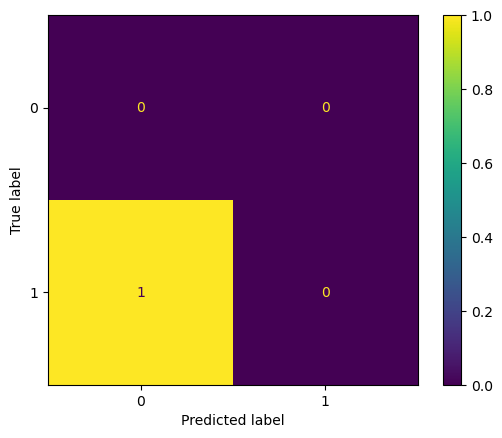

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()